Tyfenn Eloy  
Mathias Berthonneau  
Arthur-Louis Bonneau  
Loris Nezan

<h1 style="text-align:center">Process Mining</h1>
<h2 style="text-align:center">Project - Study of potential bias in the rental process</h2>

In [1]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
log_low = pm4py.read_xes('data/renting_log_low.xes')
log_medium = pm4py.read_xes('data/renting_log_medium.xes')
log_high = pm4py.read_xes('data/renting_log_high.xes')

/home/loris/.local/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
/home/loris/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 10000/10000 [00:03<00:00, 3171.24it/s]
/home/loris/.local/lib/python3.10/site-packages/pm4py/objects/log/util/dataframe_utils.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/home/loris/.local/lib/python3.10/site-packages/pm4py/objects/log/util/dataframe_utils.py:177: UserWarning: Could not infer format,

In [8]:
log_low.columns

Index(['activity', 'resource', 'time', 'concept:name', 'time:timestamp',
       '@@index', 'case:concept:name', 'case:german speaking',
       'case:yearsOfEducation', 'case:age', 'case:gender', 'case:citizen',
       'case:protected', 'case:married', 'case:@@case_index', 'case:case'],
      dtype='object')

## General trace analysis

In [9]:
CASE_ID_COL = 'concept:name'
ACTIVITY_COL = 'activity'
TIMESTAMP_COL = 'time:timestamp'

print(f"Case ID Column: {CASE_ID_COL}")
print(f"Activity Column: {ACTIVITY_COL}")
print(f"Timestamp Column: {TIMESTAMP_COL}")

Case ID Column: concept:name
Activity Column: activity
Timestamp Column: time:timestamp


Statistics for the `low` dataset:

In [10]:
num_cases = len(log_low.groupby(CASE_ID_COL))
num_events = len(log_low)

variants = pm4py.get_variants(log_low)
num_variants = len(variants)

print(f"Number of cases: {num_cases}")
print(f"Number of events: {num_events}")
print(f"Number of variants: {num_variants}")

Number of cases: 16
Number of events: 96440
Number of variants: 508


Statistics for the `medium` dataset:

In [11]:
num_cases = len(log_medium.groupby(CASE_ID_COL))
num_events = len(log_medium)

variants = pm4py.get_variants(log_medium)
num_variants = len(variants)

print(f"Number of cases: {num_cases}")
print(f"Number of events: {num_events}")
print(f"Number of variants: {num_variants}")

Number of cases: 16
Number of events: 105555
Number of variants: 610


Statistics for the `high` dataset:

In [12]:
num_cases = len(log_high.groupby(CASE_ID_COL))
num_events = len(log_high)

variants = pm4py.get_variants(log_high)
num_variants = len(variants)

print(f"Number of cases: {num_cases}")
print(f"Number of events: {num_events}")
print(f"Number of variants: {num_variants}")

Number of cases: 16
Number of events: 89972
Number of variants: 496


The general statistics of the different datasets are similar in term of size. We will be able to compare them easily.

## Drawing a general diagram of the flow

In [14]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

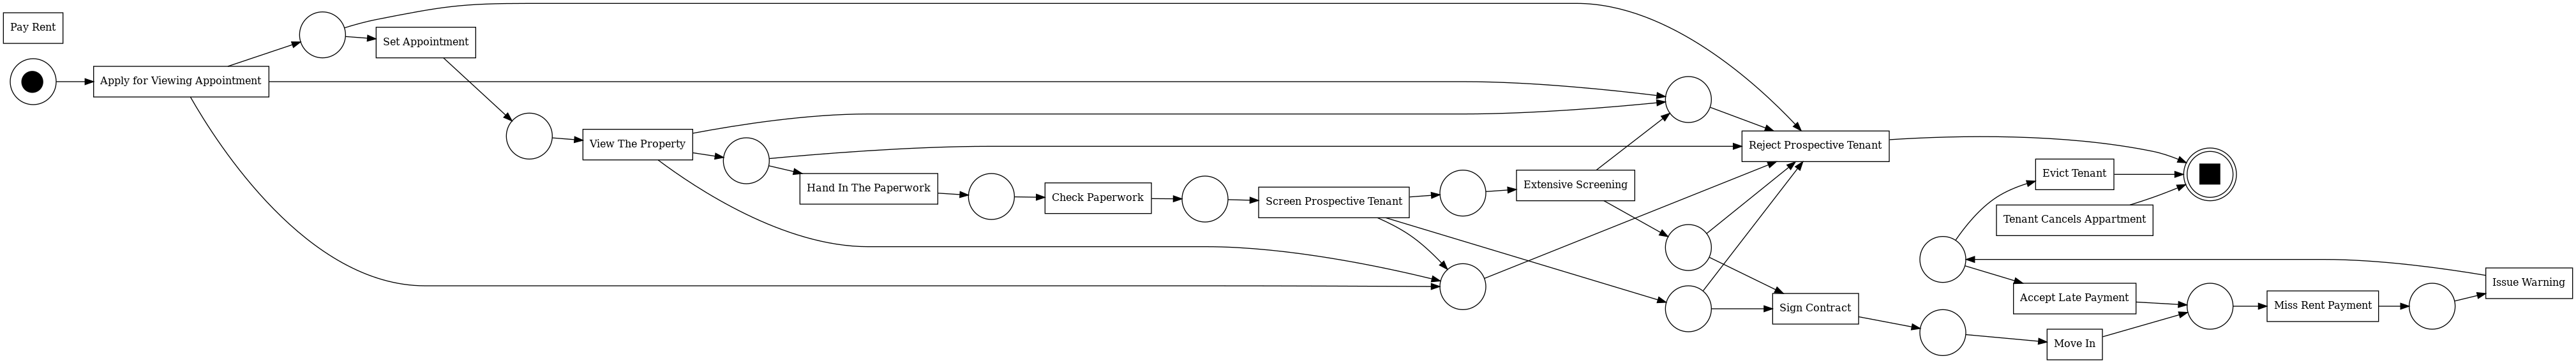

In [29]:
net, initial_marking, final_marking = alpha_miner.apply(log_low)

pm4py.view_petri_net(net, initial_marking, final_marking)

In the renting process, we can identify 4 main steps:

- The user is applying for a place
- The landlord is accepting or rejecting the application
- The user is paying the rent or not
- The user can get evicted or not

Based on this, we can look for potential bias in the process regarding the additional information we have on the users :

- Age
- Education
- Gender
- Citizenship
- Life situation (marriage, single)